---
title: Implementing Logistic Regression
author: Omar Armbruster
date: '2025-04-7'
image: "image.jpg"
description: "Those penguins won't know what hit them"
format: html
execute:
    message: false
    warning: false
---

# Abstract

This post examines the implementation of the logistic regression classifier. Using a linear model, we implement a gradient function that iteratively adjusts the weights used to score and classify a given dataset. We implement an additional term to our step function which allows for gradient descent with momentum. Using our implemented model, we perform a series of experiments that compare the efficiency of gradient descent and gradient descent with momentum, examine the effects of overfitting the model, and explore the efficacy of the model on empirical data. Based on these experiments, we can explore the capabilities and limits of logistic regression and gain a better understanding of gradient descent and one of its variations. 

# Introduction
If you've been following along closely with this blog, logistic regression may be a familiar topic. Some of you may have read my first post in which we explored logistic regression to classify the Palmer Penguins and determine their species based on other distinguishing features. For those of you who have since lain awake at night, anxiously wondering "How on earth did he do that?", fret no longer as this post is for you. Here we will build our own logistic regression model and test its limits through a series of experiments, including tests on empirical data (believe it or not, logistic regression works on non-penguin-related data as well).

We can first explore the implementation of our model [here]('https://github.com/omar-armbruster/omar-armbruster.github.io/blob/main/posts/logistic-regression/logistic.py')

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer #, NewtonOptimizer

c:\Users\omara\.conda\envs\ml451\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our implementation largely focuses on the implementation of the loss function `LogisticRegression.loss()` and the gradient function `LogisticRegression.grad()`.

We define our loss function as $$L(\textbf{w}) = \frac{1}{n}\sum^n_{i = 1}[-y_ilog(\sigma(s_i)) - (1 - y_i)log(1-\sigma(s_i))]$$ where $w$ represents the scoring weights, $s_i$ represents the score of the $i$th entry of the data defined by $$s_i = \langle \textbf{w}, \textbf{X}_i \rangle,$$ $y_i$ is the label of the $i$th entry, and $\sigma(s)$ is the sigmoid function defined by $$\sigma(s) = \frac{1}{1 + e^{-s}}.$$ The python implementation is given by 
``` python
    def loss(self,X,y):
        n = len(X)
        sigmoid = lambda x: 1/(1 + torch.exp(-x))
        s = self.score(X)
        l = (1/n)*torch.sum(-y*torch.log(sigmoid(s)) - (1 - y)*torch.log(1 - sigmoid(s)))
        return l
```
We can use the loss function to determine when the model is adequately trained. Because loss decreases as the number of accurate predictions increases, we expect optimal training to be achieved when the loss is at a minimum. We will observe later that the loss will plateau approaching $0$ once we have achieved the optimal weights.

Our gradient function is defined as $$\nabla L(\textbf{w}) = \frac{1}{n}\sum_{i = 1}^n (\sigma{s_i} - y_i)\textbf{x}_i$$, which is implemented as follows:
``` python 
def grad(self, X,y):
        sigmoid = lambda x: 1/(1 + torch.exp(-x))
        s = self.score(X)
        grad = torch.mean((sigmoid(s) - y)[:,None]*X, axis = 0)
        return grad
```
The gradient function is crucial for defining our step function, which utilizes **gradient descent** to achieve the optimal scoring weights. The weights are updated iteratively in the direction of the absolute minimum such that $$\textbf{w}_{k + 1} \leftarrow \textbf{w}_k - \alpha \nabla L(\textbf{w}_k) + \beta(\textbf{w}_k - \textbf{w}_{k -1})$$

where $\alpha$ and $\beta$ are learning rate parameters. The first term defines the core of our gradient descent algorithm where a positive gradient indicates that our weights are too high (and thus the gradient is subtracted) and a negative gradient indicates that out weights are too low (so the gradient is added to the weights). The learning rate $\alpha$ defines the contribution of our gradient to the weights, thus determining how large of jumps we make in our weights at each step. The second term is the momentum term (completing the implementation of **gradient descent with momentum**), which allows for a speed up in the gradient descent process by increasing the size of each jump in weights while the weights are far from the minimum and decreasing the size of each jump when the weights approach their minimum.

# Experiments 
This is where the fun begins. We can perform our experiments on our implemented logistic regression model to determine how it performs in a variety of training conditions. As always, we must begin by importing torch and matplotlib.


In [2]:
import torch
import matplotlib.pyplot as plt

We define a data generation function `classification_data()`, which will be used for the first three of our experiments. This function places the first half of the points in one group and the other half in the other group. Then through a gaussian distribution whose standard deviation is defined by the `noise` parameter, it adds noise, creating a set of unique data points.

In [3]:
## Sourced from Phil Chodrow Lecture Notes
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

We define the `plot_data()` and `draw_line()` functions to help us visualize the decision boundary on $2D$ data. We also define `plot_loss()` to track the improvements in loss for each iteration and `plot_results()`, which will give us a side-by-side visualization of the decision region and changes in loss.

In [4]:
## Data plotting function sourced from Phil Chodrow Lecture Notes
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "PuOr", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

## Boundary drawing function sourced from Phil Chodrow Lecture Notes
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

def plot_loss(loss, ax, **kwargs):
    ax.plot(loss, **kwargs)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')

def plot_results(LR, X, y, loss, ax):
    plot_data(X,y,ax[0])
    draw_line(LR.w, -1, 2, ax[0], color = 'black')
    ax[0].set_title('Decision Boundary')
    ax[1].set_title('Loss')
    plot_loss(loss, ax[1])

We define the following data for the first two experiments, which is composed of two linearly separable clusters.

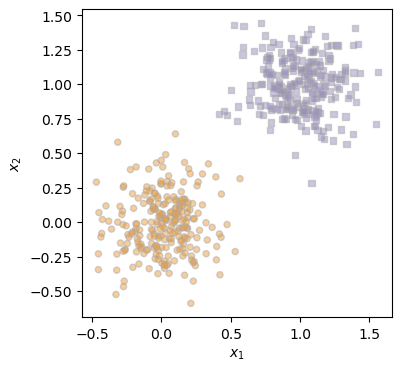

In [6]:
X, y = classification_data(n_points = 500, noise = 0.2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_data(X, y, ax)

## Vanilla Gradient Descent
We first perform logistic regression using vanilla gradient descent, meaning gradient descent where $\beta = 0$. We define the `LogisticRegression` model we implemented as well as the `GradientDescentOptimizer`, which will update the weights at each iteration. The training loop here is fairly simple, calling the `step()` function for a predetermined number of iterations. We also save the loss at each step so we can determine when the model has converged.

In [7]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)


loss = []
for _ in range(3000):
    l = LR.loss(X,y)
    loss.append(l)
    opt.step(X, y, alpha = 0.1, beta = 0)

After $3000$ iterations, we notice that the loss converges to a value close to $0$. We can also observe that the our decision boundary (dictated by the optimal weights) perfectly divides the data into their correct clusters. Nice!

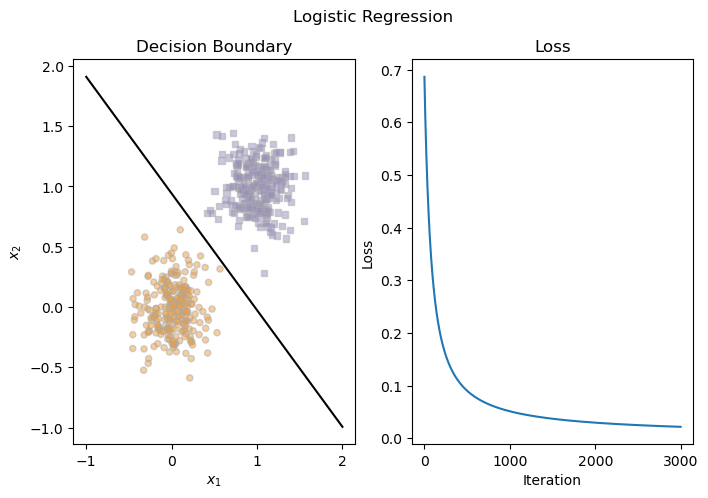

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
fig.suptitle('Logistic Regression')
plot_results(LR, X, y, loss, ax)

# Gradient Descent with Momentum
We can now train our model on the same data but using momentum, which we expect to achieve similar results but in fewer iterations. We define our momentum parameter as $\beta = 0.9$, which will allow for larger changes in the weights while the weights are far from the minimum. We also set the model to train for a fewer number of iterations as we expect it to converge more quickly.

In [9]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)


loss = []
for _ in range(500):
    l = LR.loss(X,y)
    loss.append(l)
    opt.step(X, y, alpha = 0.1, beta = 0.9)

We plot the decision boundaries and loss once again and notice that we achieve the same decision boundary (and perfect clustering) but in fewer iterations. Our loss achieves the same runoff behavior, approaching $0$, but at around $500$ iterations as opposed to $3000$ iterations.

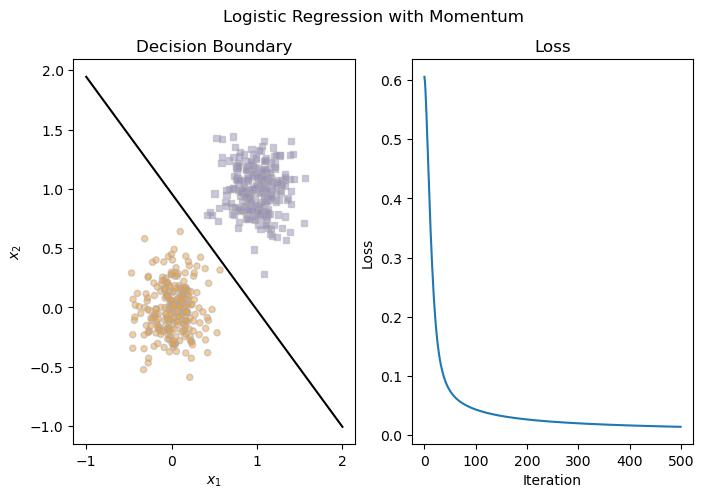

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
fig.suptitle('Logistic Regression with Momentum')
plot_results(LR, X, y, loss, ax)

# Overfitting
Our third experiment examines the potential downside of **overfitting** the model, in which the model trains so specifically to the training data that it achieves poor results on the testing data. In order to do this, we must first define our training dataset Xo1 and our testing dataset Xo2. This effect is most observable with a higher number of features, so we define the number of dimensions `p_dims` to be $500$ while the number of observations `n_points` is set to only $100$.

In [11]:
Xo1, yo1 = classification_data(n_points = 100, noise = 0.8, p_dims = 500)
Xo2, yo2 = classification_data(n_points = 100, noise = 0.8, p_dims = 500)

Using gradient descent with momentum, we train our model and find that we achieve a convergence in the loss after $500$ iterations.

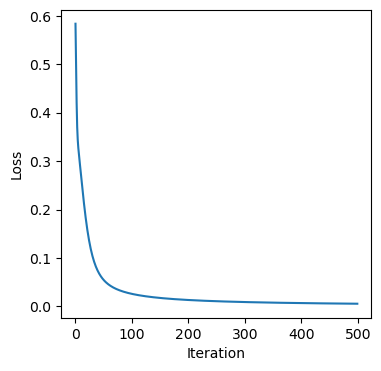

In [12]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss = []
for _ in range(500):
    l = LR.loss(Xo1,yo1)
    loss.append(l)
    opt.step(Xo1, yo1, alpha = 0.005, beta = 0.9)

fig, ax = plt.subplots(1,1, figsize = (4,4))
plot_loss(loss, ax)

While our loss is very close to $0$ and the corresponding training accuracy is $1.0$, we cannot say that our model is trained optimally. When we look at the testing accuracy, we notice a substantial decrease in the accuracy ($0.86$), meaning that our model does not generalize well to new data. Given that the whole purpose of machine learning is to be able to make reliable predictions, this is _bad_. In the future, we can look to avoid scenarios like this so that we can rely on our models to make accurate predictions.

In [13]:
predo1 = LR.predict(Xo1)
acco1 = ((predo1 == yo1)*1.0).mean()
predo2 = LR.predict(Xo2)
acco2 = ((predo2 == yo2)*1.0).mean()
print('The accuracy on the training data is: {}. The accuracy on the testing data is: {}'.format(acco1, acco2))

The accuracy on the training data is: 1.0. The accuracy on the testing data is: 0.8600000143051147


# Empirical Data
As promised in the introduction, logistic regression does in fact work on data that are not related to penguins. For our empirical data experiment, we will be examining the [*Zachary's Karate Club*](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) network, which is one of the qintisential networks in the field of network science. This network models a real karate club, where each node represents a member of the club and edges are drawn between people (nodes) who frequently interact with one another. What makes this network interesting is that the club eventually split into two factions: one that stayed loyal to the original leadership ("Officers") and one that left the original club to follow one of the intstructors ("Mr. Hi"). This schism makes for an interesting study in network science, as measurements like centrality can be used to determine who the eventual club leaders would be as well as who was likely to join each faction. We can visualize the network below where Node $33$ represents the original officer John A. and Node $0$ represents the defecting intstructor Mr. Hi.

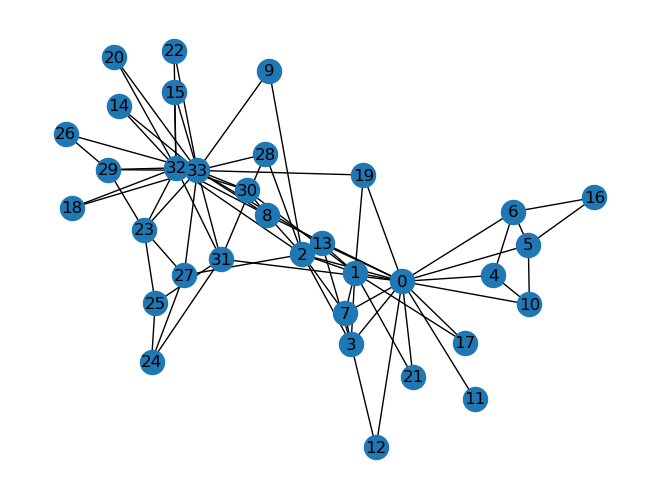

In [14]:
import networkx as nx
G = nx.karate_club_graph()
nx.draw(G, with_labels = True)

Rather than using network science principles to predict the labels of each node post-schism, we are going to apply the logistic regression model. Admittedly, this is a weird (one could call it edge-y) thing to do, but my psyche is plagued with questions like *What if we used an adjacency matrix as a feature matrix?*, so now we have to find out. There are a few things to consider when working an adjacency matrix rather than a feature matrix. Namely:

* It would be very difficult to subset our network and look at nodes in isolation when performing our train-test split
* We do not have that many data points 
* The entire dataset is binary

For this experiment, we plan to perform the train-test split the same way we would a feature matrix. What this means is that we allocate some of the rows towards testing data, while keeping the columns intact. The implication here is that we are still training the model on the entire network (since a symmetrical adjacency matrix means the edge information will be retained in the columns), but are only giving our logistic regression model some of the cluster labels. The idea is that the model will predict the remaining labels in the testing dataset.

There is not much we can do about the other two considerations, but they are important to note as they indicate our model will be at risk of overfitting.

Before we fit the model, we need to retrieve our data, which involves converting the labels to binary where $0$ represents the Officer group and $1$ represents the Mr. Hi group. We then use the provided edges of the graph to form our adjacency/feature matrix.

In [15]:

labels = torch.tensor([1 if G.nodes[i]['club'] == 'Mr. Hi' else 0 for i in range(len(G.nodes))])
A = torch.zeros((len(G.nodes), len(G.nodes)))
for edge in G.edges:
    A[edge[0], edge[1]] = 1.0
    A[edge[1], edge[0]] = 1.0
A

tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

If we examine the labels in their original order, we notice that the first half of the nodes are largely in the Mr. Hi group and the second half are largely in the Officer group. As such, we define a random permutation so that our training, validation, and testing data have a more even split in the labels.

In [41]:
p = torch.randperm(len(labels))
X = A[p, :][:,p]
y = labels[p]

We split our plethora of data (all $34$ rows!) into a training, validation, and testing set, which are composed of $60\%$, $20\%$, and $20\%$ of the data respectively.

In [42]:
split_train = 0.6
split_test = 0.2
idx1 = int(split_train * len(y))
idx2 = int((1 - split_test) * len(y))
X_train = X[:idx1, :]
y_train = y[:idx1]
X_valid = X[idx1:idx2, :]
y_valid = y[idx1:idx2]
X_test = X[idx2:, :]
y_test = y[idx2:]

We first perform our experiment without momentum, which achieves convergence in both testing and validation after roughly $500$ iterations. As we can see from the loss plot, the training loss converges to a value much lower than the validation loss, which is a strong indicator that our model may be overfitting. 

Text(0.5, 1.0, 'Karate Club Loss without Momentum')

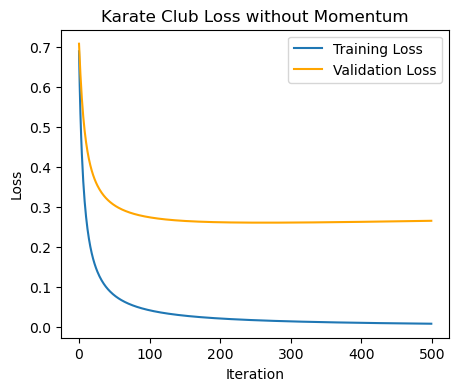

In [43]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss = []
valid_loss = []
for _ in range(500):
    l = LR.loss(X_train,y_train)
    vl = LR.loss(X_valid, y_valid)
    loss.append(l)
    valid_loss.append(vl)
    opt.step(X_train, y_train, alpha = 0.5, beta = 0)

fig, ax = plt.subplots(1,1, figsize = (5,4))
plot_loss(loss, ax, label = 'Training Loss')
plot_loss(valid_loss, ax, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Karate Club Loss without Momentum')

Interestingly enough, we still obtain a perfect testing accuracy despite the signs of overfitting. As indicated by our loss plots, the validation set is unable to achieve perfect classification accuracy, although based on the size of the validation set, this only amounts to only one misclassified node.

In [44]:
pred_train = LR.predict(X_train)
acc1 = ((pred_train == y_train)*1.0).mean()
pred_valid = LR.predict(X_valid)
acc2 = ((pred_valid == y_valid)*1.0).mean()
pred_test = LR.predict(X_test)
acc3 = ((pred_test == y_test)*1.0).mean()
print('The accuracy on the training data is: {}. The accuracy on the validation data is: {}. The accuracy on the testing data is: {}.'.format(acc1, acc2, acc3))

The accuracy on the training data is: 1.0. The accuracy on the validation data is: 0.8571428656578064. The accuracy on the testing data is: 1.0.


We can apply the same logic but with momentum, which achieves a similar result but in $200$ iterations (with convergence occuring after around $50$). 

Text(0.5, 1.0, 'Karate Club Loss with Momentum')

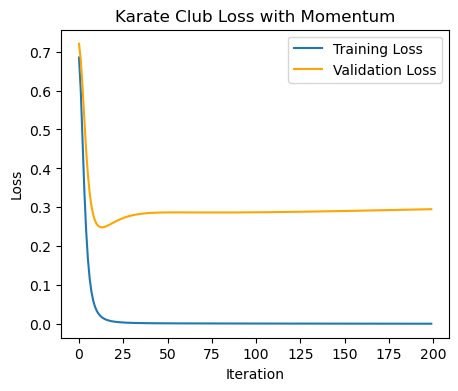

In [45]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss = []
valid_loss = []
for _ in range(200):
    l = LR.loss(X_train,y_train)
    vl = LR.loss(X_valid, y_valid)
    loss.append(l)
    valid_loss.append(vl)
    opt.step(X_train, y_train, alpha = 0.5, beta = 0.9)

fig, ax = plt.subplots(1,1, figsize = (5,4))
plot_loss(loss, ax, label = 'Training Loss')
plot_loss(valid_loss, ax, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Karate Club Loss with Momentum')

When we calculate the accuracy, we find the exact same results as the non-momentum case, further proving our claim that gradient descent with momentum can achieve the same results as vanilla gradient descent but faster.

In [46]:
pred_train = LR.predict(X_train)
acc1 = ((pred_train == y_train)*1.0).mean()
pred_valid = LR.predict(X_valid)
acc2 = ((pred_valid == y_valid)*1.0).mean()
pred_test = LR.predict(X_test)
acc3 = ((pred_test == y_test)*1.0).mean()
print('The accuracy on the training data is: {}. The accuracy on the validation data is: {}. The accuracy on the testing data is: {}.'.format(acc1, acc2, acc3))

The accuracy on the training data is: 1.0. The accuracy on the validation data is: 0.8571428656578064. The accuracy on the testing data is: 1.0.


For the sake of examining why we are able to achieve such high accuracy on this dataset, I have plotted the weights where each weight will correspond to one of the $34$ people in the karate club. We can analyze these weights as a ranking of how influential each person in the network is. Nodes with edges connecting them to the higher weight nodes will be more likely to be in the same group as that higher weight edge. I've labeled the two club leaders John A. and Mr. Hi in orange, and as we might guess, these two have the greatest magnitude weights indicating the highest influence. What is interesting is that these two nodes are not significantly higher in magnitude than all of the other nodes. We can see that there are a number of nodes with very negative weights, indicating other influential members within the club. 

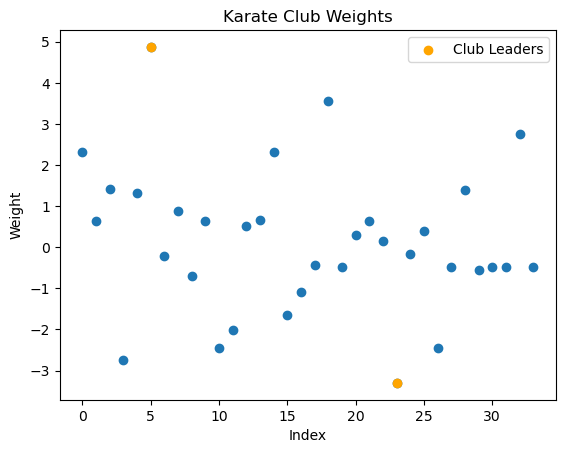

In [48]:
idxs = torch.linspace(0,len(G.nodes) - 1, len(G.nodes), dtype = int)

mrhi = torch.where(p == 0)[0][0]
johna = torch.where(p == 33)[0][0]
plt.scatter(idxs, LR.w)
plt.scatter([mrhi, johna], [LR.w[mrhi], LR.w[johna]], color = 'orange', label = 'Club Leaders')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.title('Karate Club Weights')
plt.legend()

# Conclusion
Throughout this post we examine the implementation of logistic regression, implementing gradient descent and gradient descent with momentum to achieve the optimal weights needed for effective binary classification. We examine how these two methods can be implemented and modified using varying learning rate parameters as well as how they are able to achieve similar results with varying speeds. We indicate that the momentum term can lead to significant speedups in the training process without any compromise in accuracy. We also examine overfitting the data, which can occur when we have a greater number of features than observations, leading to decreased predictive power on new data. Finally we examine the Zachary's Karate Club network and apply our model to it to predict which members of the club went to which faction after the schism. While we were able to achieve accurate results, our model still showed signs of overfitting, which could be addressed with future work. Through lessons in gradient descent, loss, and overfitting, we set the stage for implementing carefully constructed and effective deep learning models. Those penguins truly are not ready.